In [1]:
# === 0. Load libraries (無變動) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay,
                             mean_squared_error)
import joblib

In [5]:
# === 1. Read data ===
df = pd.read_excel("window_breakage_data.xlsx")

# === 2. Basic cleanup (Drop duplicate & leakage columns) ===
df = df.drop(columns=["YldFrctn"])              # duplicate
leak_cols = ["Yield", "YieldX", "PF Rowstate"]
df = df.drop(columns=leak_cols)                 # remove leakage

# --- NEW STEP: handle the single NaN in Pass/Fail -----------------
df = df.dropna(subset=["Pass/Fail"])      # simplest: just drop that 1 row

# === 3. Encode target for classification ===
df["PassFail_bin"] = df["Pass/Fail"].map({"Pass": 1, "Fail": 0})

# === 4. Split features / targets ===
X = df.drop(columns=["Pass/Fail", "PassFail_bin", "Breakage Rate"])
y_cls = df["PassFail_bin"]
y_reg = df["Breakage Rate"]                     # still present for regression

numeric_feats = X.select_dtypes(include=["float", "int"]).columns
categorical_feats = X.select_dtypes(include=["object", "category"]).columns

In [6]:
# === 5. Preprocessing pipelines ===
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),  # or "most_frequent"
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_feats),
    ("cat", categorical_transformer, categorical_feats)
])

---- Confusion Matrix ----
[[ 66  13]
 [ 29 152]]

---- Classification Report ----
              precision    recall  f1-score   support

           0      0.695     0.835     0.759        79
           1      0.921     0.840     0.879       181

    accuracy                          0.838       260
   macro avg      0.808     0.838     0.819       260
weighted avg      0.852     0.838     0.842       260

ROC-AUC: 0.9285264703825442


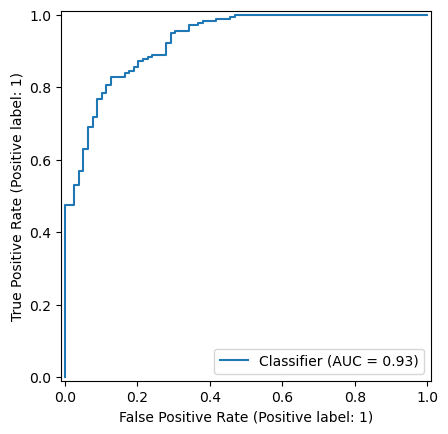


---- 5-Fold CV (mean) ----
test_accuracy     0.839231
test_precision    0.921416
test_recall       0.841260
test_f1           0.879449
test_roc_auc      0.917807
dtype: float64

RMSE (test): 4.081628732699574
CV RMSE (mean): 3.8091176807238645


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# === 6. Train-test split ===
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = train_test_split(
    X, y_cls, y_reg, test_size=0.2, random_state=42,
    shuffle=True, stratify=y_cls
)

# === 7. Classification: Logistic Regression ===
clf_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
clf_pipe.fit(X_train, y_train_cls)

y_pred_cls  = clf_pipe.predict(X_test)
y_pred_prob = clf_pipe.predict_proba(X_test)[:, 1]

print("---- Confusion Matrix ----")
print(confusion_matrix(y_test_cls, y_pred_cls))
print("\n---- Classification Report ----")
print(classification_report(y_test_cls, y_pred_cls, digits=3))
print("ROC-AUC:", roc_auc_score(y_test_cls, y_pred_prob))

RocCurveDisplay.from_predictions(y_test_cls, y_pred_prob)
plt.show()

# 5-fold CV (Stratified)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_cls = cross_validate(
    clf_pipe, X, y_cls, cv=skf,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
)
print("\n---- 5-Fold CV (mean) ----")
print(pd.DataFrame(cv_cls).mean()[["test_accuracy", "test_precision",
                                   "test_recall", "test_f1", "test_roc_auc"]])

# === 8. Regression: Linear Regression ===
reg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])
reg_pipe.fit(X_train, y_train_reg)
y_pred_reg = reg_pipe.predict(X_test)
rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
print("\nRMSE (test):", rmse)

# 5-fold CV for regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_reg = cross_validate(reg_pipe, X, y_reg, cv=kf,
                        scoring="neg_root_mean_squared_error")
print("CV RMSE (mean):", -cv_reg["test_score"].mean())

# === 9. Save baseline models ===
# joblib.dump(clf_pipe, "baseline_logreg.pkl")
# joblib.dump(reg_pipe, "baseline_linreg.pkl")

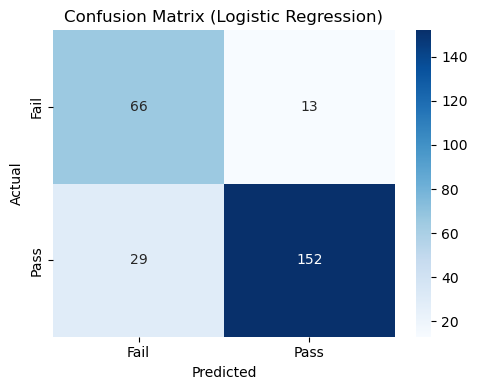

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ----- Compute CM -----
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=[0, 1])
labels = ["Fail", "Pass"]

# ----- Plot -----
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.show()
